In [2]:
# Import required libraries
import numpy as np
from tqdm import tqdm
import concurrent.futures
import numba as nb
from matplotlib import pyplot as plt

In [3]:
# Set parameters for simulation
farm_population = 1
packer_population = 1
distributor_population = 1
retailer_population = 1
customer_population = 5000

plot_per_farm = 1856
box_per_P = 31562
box_per_D = 31562
box_per_R = 31562

box_per_plot = 17
contamination_rate = 0.06

d_test_rate = 0.0
r_test_rate = 0.0

box_ids_l=[]
box_ids_C_l=[]
dropped_boxes_F_l=[]
dropped_boxes_P_l=[]
dropped_boxes_D_l=[]
dropped_boxes_R_l=[]
dropped_boxes_C_l=[]
detection_percent_l=[]

iterations = 10

# Test cost at each stage
test_cost_F = 350
test_cost_P = 50
test_cost_D = 50
test_cost_R = 50

# Customer demand
box_cap = 50
number_plot = farm_population * plot_per_farm
number_box = number_plot * box_per_plot
customer_number = int (number_box * box_cap * (0.80 - contamination_rate))
customer_demand = np.floor(np.abs(np.random.normal(1, 2, (customer_number, 1))))


# Customer illness cost
ill_rate = 0.04
hospital_rate = 0.0164
death_rate = 0.000041
ill_compensation = 719
hospital_compensation = 18438
death_compensation = 1764112

# Recall and Trace cost
unit_recall_labor_cost = 10
unit_trace_labor_cost = 10
price_per_box = 100

# Transportation cost
unit_trans_cost = 0.007
cost_indicator = 1
F_P_distance = 5
P_D_distance = 2983
D_R_distance = 11


In [4]:
# Define functions 

# generate box id
#@nb.njit(nopython=True)
def generate_box_id(farm_idx, plot_idx, box_idx):
    return farm_idx * 10000000000 + plot_idx * 100000 + box_idx * 10

# generate contaminated box mask
#@nb.njit(parallel=True)
def generate_contamination_mask(total_boxes, contamination_rate):
    contaminated_boxes = int(total_boxes * contamination_rate)
    mask = np.zeros(total_boxes, dtype=np.bool_)
    mask[:contaminated_boxes] = True
    np.random.shuffle(mask)
    return mask

def generate_box_ids_numpy(farm_population, plot_per_farm, box_per_plot):
    farm_range = np.arange(1, farm_population + 1)
    plot_range = np.arange(1, plot_per_farm + 1)
    box_range = np.arange(1, box_per_plot + 1)
    farm_grid, plot_grid, box_grid = np.meshgrid(farm_range, plot_range, box_range)
    box_ids = (farm_grid * 10000000000 + plot_grid * 100000 + box_grid).ravel()
    return box_ids

# define testing at each stage

'''
# Only contaminated tested boxes are dropped
def run_stage(box_ids, contamination_mask, test_rate):
    tested_boxes_mask = np.random.rand(box_ids.shape[0]) < test_rate
    tested_contaminated_boxes = box_ids[np.logical_and(contamination_mask, tested_boxes_mask)]
    if tested_contaminated_boxes.size > 0:
        mask = np.isin(box_ids, tested_contaminated_boxes)
        box_ids_n = box_ids[~mask]
        contamination_mask = contamination_mask[~mask]
        dropped_boxes = set(tested_contaminated_boxes)
    else:
        box_ids_n = box_ids
        dropped_boxes = set()
    remaining_boxes = box_ids_n[~np.isin(box_ids_n, tested_contaminated_boxes)]
    return remaining_boxes, contamination_mask, dropped_boxes'''
# All boxes in same plot in which tested contaminated box is found are dropped
def run_stage(box_ids, contamination_mask, test_rate,box_per_plot):
    tested_boxes_mask = np.random.rand(box_ids.shape[0]) < test_rate
    tested_contaminated_boxes = box_ids[np.logical_and(contamination_mask, tested_boxes_mask)]
    if tested_contaminated_boxes.size > 0:
        plot_farm_ids_tested = tested_contaminated_boxes - tested_contaminated_boxes % 100
        #plot_farm_ids_all = box_ids - box_ids % 100
        tested_contaminated_boxes_all=np.repeat(np.unique(plot_farm_ids_tested),box_per_plot)+ np.tile(np.arange(1, box_per_plot + 1),np.unique(plot_farm_ids_tested).shape[0])
        #plot_boxes = np.array([generate_box_id(farm_idxs[i], plot_idxs[i], box_idx) for i in range(tested_contaminated_boxes.size) for box_idx in range(1, box_per_plot+1)])
        #remaining_boxes = box_ids[~np.isin(box_ids, dropped_boxes)]
        #tested_contaminated_boxes= np.array(list(dropped_boxes))
        dropped_boxes = set(np.unique(tested_contaminated_boxes_all))
        mask = np.isin(box_ids, tested_contaminated_boxes_all)
        contamination_mask = contamination_mask[~mask]
        box_ids_n = box_ids[~mask]
        #dropped_boxes = set(tested_contaminated_boxes)
    else:
        dropped_boxes = set()
        box_ids_n = box_ids
    remaining_boxes = box_ids_n

    return remaining_boxes, contamination_mask, dropped_boxes, sum(tested_boxes_mask)
# Cost Calculation 

# Transportation cost
def transportation_cost(box_ids_F_P,box_ids_P_D,box_ids_D_R):
    trans_cost_F_P = (len(box_ids_F_P) // box_per_P +1 )* F_P_distance * unit_trans_cost
    trans_cost_P_D = (len(box_ids_P_D) // box_per_D +1 )* P_D_distance * unit_trans_cost
    trans_cost_D_R = (len(box_ids_D_R) // box_per_R + 1) * D_R_distance * unit_trans_cost
    return trans_cost_D_R+trans_cost_P_D+trans_cost_F_P

def testing_cost(tests_F,tests_P,tests_D,tests_R):
    return tests_F*test_cost_F+tests_P*test_cost_P+tests_D*test_cost_D+tests_R*test_cost_R

# Customer consumption and illness report 
def customer_illness_cost(box_ids_R_C,contamination_mask):
    boxes_allotted = np.zeros((customer_number,2),dtype=int)
    all_boxes= box_ids_R_C
    boxes_allotted_cont = np.zeros(customer_number,dtype=bool)
    current_box_cap = box_cap
    current_box_id = 0
    current_box_contaminated = contamination_mask[current_box_id]
    contaminated=sum(contamination_mask)
    #customer_demand = np.sort(customer_demand)[::-1]
    if contaminated:
        for i, current_customer_demand in enumerate(customer_demand):
            if current_customer_demand == 0:
                continue
            else:
                if current_box_cap - current_customer_demand >= 0:
                    #boxes_allotted[i,0]=all_boxes[current_box_id]
                    current_box_cap -= current_customer_demand
                    boxes_allotted_cont[i]=current_box_contaminated
                    if current_box_cap == 0:
                        current_box_id += 1
                        if current_box_id < len(all_boxes):
                            current_box_contaminated = contamination_mask[current_box_id]
                        else:
                            current_box_contaminated = False                      
                        current_box_cap = box_cap
                else: 
                    #boxes_allotted[i,0]=all_boxes[current_box_id]
                    current_box_id += 1
                    if current_box_id < len(all_boxes):
                        cont= contamination_mask[current_box_id]
                    else:
                        cont=current_box_contaminated
                    current_box_cap = box_cap - current_customer_demand - current_box_cap
                    boxes_allotted_cont[i]=cont+current_box_contaminated 
                    current_box_contaminated = cont
                    #boxes_allotted[i,1]=all_boxes[current_box_id]
        customers_contaminated = sum(boxes_allotted_cont)
    else:
        customers_contaminated = 0

    ill_number = np.random.rand(customers_contaminated, 1)
    hospital_number = np.random.rand(customers_contaminated, 1)
    death_number = np.random.rand(customers_contaminated, 1)

    death_number = death_number < death_rate
    death_case_number = np.sum(death_number)

    hospital_number = hospital_number < hospital_rate
    hospital_case_number = np.sum(hospital_number)

    ill_number = ill_number < ill_rate
    ill_case_number = np.sum(ill_number)
    cust_cost = death_case_number * death_compensation + hospital_case_number * hospital_compensation + ill_case_number * ill_compensation
    return cust_cost

def recall_cost(contamination_mask):
    return sum(contamination_mask)* (unit_recall_labor_cost+unit_trace_labor_cost+price_per_box)
    
    
# Function to check if a value is in an array
#@nb.njit(parallel=True) 
def isin(a, b):
    out=np.empty(a.shape[0], dtype=nb.boolean)
    b = set(b)
    for i in nb.prange(a.shape[0]):
        if a[i] in b:
            out[i]=True
        else:
            out[i]=False
    return out


    
# Run testing and return the number of boxes dropped at each stage
def run_test():
    total_boxes = farm_population * plot_per_farm * box_per_plot
    box_ids = generate_box_ids_numpy(farm_population, plot_per_farm, box_per_plot)    
    contamination_mask = generate_contamination_mask(total_boxes, contamination_rate)
    box_ids_F_P, contamination_mask1, dropped_boxes_F,tests_F = run_stage(box_ids, contamination_mask, f_test_rate,box_per_plot)
    box_ids_P_D, contamination_mask2, dropped_boxes_P,tests_P = run_stage(box_ids_F_P, contamination_mask1, p_test_rate,box_per_plot)
    box_ids_D_R, contamination_mask3, dropped_boxes_D,tests_D = run_stage(box_ids_P_D, contamination_mask2, d_test_rate,box_per_plot)
    box_ids_R_C, contamination_mask4, dropped_boxes_R,tests_R = run_stage(box_ids_D_R, contamination_mask3, r_test_rate,box_per_plot)
    #box_ids_C, contamination_mask, dropped_boxes_C = run_stage(box_ids_R, contamination_mask, c_test_rate,box_per_plot)

    total_cost = transportation_cost(box_ids_F_P,box_ids_P_D,box_ids_D_R)+customer_illness_cost(box_ids_R_C,contamination_mask4)+testing_cost(tests_F,tests_P,tests_D,tests_R)+recall_cost(contamination_mask4)
    #return box_ids, box_ids_F_P, box_ids_P_D, box_ids_D_R, box_ids_R_C, contamination_mask, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R
    return total_cost


In [10]:
import tensorflow as tf
import concurrent.futures

iterations = 2
ftest_rate = []
ptest_rate = []
costs_mean = []
costs_std = []

def run_test_wrapper(args):
    f_test_rate, p_test_rate, i = args
    total_cost = run_test()
    return i, total_cost

def run_tests(f_test_rate, p_test_rate):
    costs = []
    for i in range(iterations):
        total_cost = run_test()
        costs.append(total_cost)
    return f_test_rate, p_test_rate, np.mean(costs), np.std(costs)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    results = []
    for f_test_rate in np.arange(0.01,0.05,0.01):
        for p_test_rate in np.arange(0.01,0.05,0.01):
            results.append(strategy.run(run_tests, args=(f_test_rate, p_test_rate)))
    
    for result in results:
        f_test_rate, p_test_rate, cost_mean, cost_std = result
        ftest_rate.append(f_test_rate)
        ptest_rate.append(p_test_rate)
        costs_mean.append(cost_mean)
        costs_std.append(cost_std)

ModuleNotFoundError: No module named 'tensorflow'

In [14]:
!pip install tensorflow==2.7.0


ERROR: Could not find a version that satisfies the requirement tensorflow==2.7.0 (from versions: none)
ERROR: No matching distribution found for tensorflow==2.7.0

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [9]:
import concurrent.futures

iterations = 10
ftest_rate = []
ptest_rate = []
costs_mean = []
costs_std = []

def run_test_wrapper(args):
    f_test_rate, p_test_rate, i = args
    total_cost = run_test()
    return i, total_cost

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for f_test_rate in np.arange(0.01,0.05,0.01):
        for p_test_rate in np.arange(0.01,0.05,0.01):
            for i in range(iterations):
                args = (f_test_rate, p_test_rate, i)
                futures.append(executor.submit(run_test_wrapper, args))
            
    for future in concurrent.futures.as_completed(futures):
        i, total_cost = future.result()
        f_test_rate = np.arange(0.01,0.05,0.01)[int(i/(iterations**2))]
        p_test_rate = np.arange(0.01,0.05,0.01)[int((i/iterations)%4)]
        if i%iterations == 0:
            costs = []
        costs.append(total_cost)
        if i%iterations == iterations-1:
            ftest_rate.append(f_test_rate)
            ptest_rate.append(p_test_rate)
            costs_mean.append(np.mean(costs))
            costs_std.append(np.std(costs))


KeyboardInterrupt: 

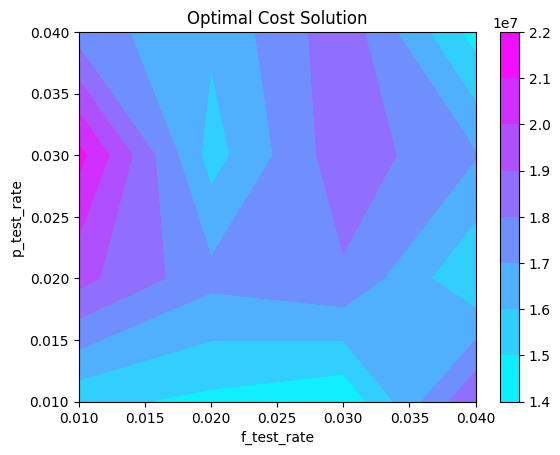

In [6]:
import matplotlib.pyplot as plt

# Create a grid of f_test_rate and p_test_rate values
f, p = np.meshgrid(np.arange(0.01, 0.05, 0.01), np.arange(0.01, 0.05, 0.01))

# Reshape the costs_mean array to match the grid shape
c = np.reshape(costs_mean, (4, 4))

# Create a contour plot of the costs_mean
fig, ax = plt.subplots()
cp = ax.contourf(f, p, c, cmap='cool')
plt.colorbar(cp)

# Add labels and title
ax.set_xlabel('f_test_rate')
ax.set_ylabel('p_test_rate')
ax.set_title('Optimal Cost Solution')

plt.show()


Optimal f_test_rate: 0.01
Optimal p_test_rate: 0.01
Optimal cost: 14186888.993


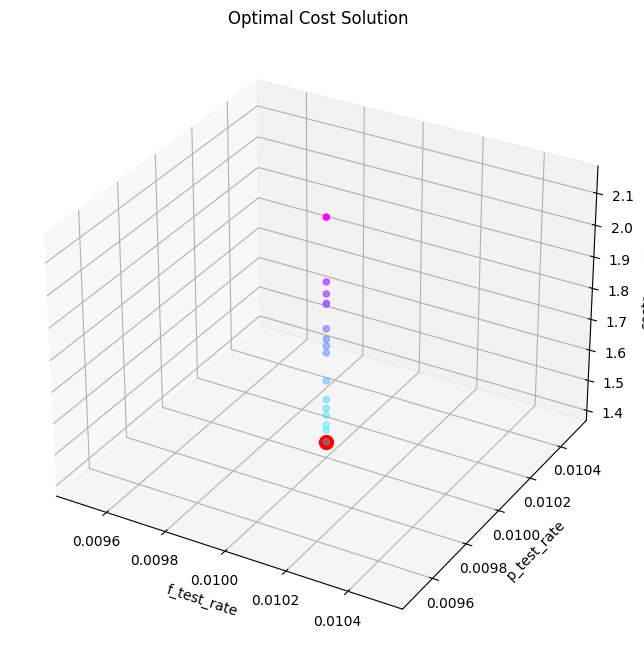

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Find the index of the minimum value in the costs_mean array
min_idx = np.argmin(costs_mean)

# Get the corresponding values of f_test_rate and p_test_rate
opt_f = ftest_rate[min_idx]
opt_p = ptest_rate[min_idx]
opt_cost = costs_mean[min_idx]

# Print the optimal values
print('Optimal f_test_rate:', opt_f)
print('Optimal p_test_rate:', opt_p)
print('Optimal cost:', opt_cost)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ftest_rate, ptest_rate, costs_mean, c=costs_mean, cmap='cool')
ax.scatter(opt_f, opt_p, opt_cost, c='red', s=100)
ax.set_xlabel('f_test_rate')
ax.set_ylabel('p_test_rate')
ax.set_zlabel('costs_mean')
ax.set_title('Optimal Cost Solution')
plt.show()


Optimal f_test_rate: 0.01
Optimal p_test_rate: 0.01
Optimal cost: 14186888.993


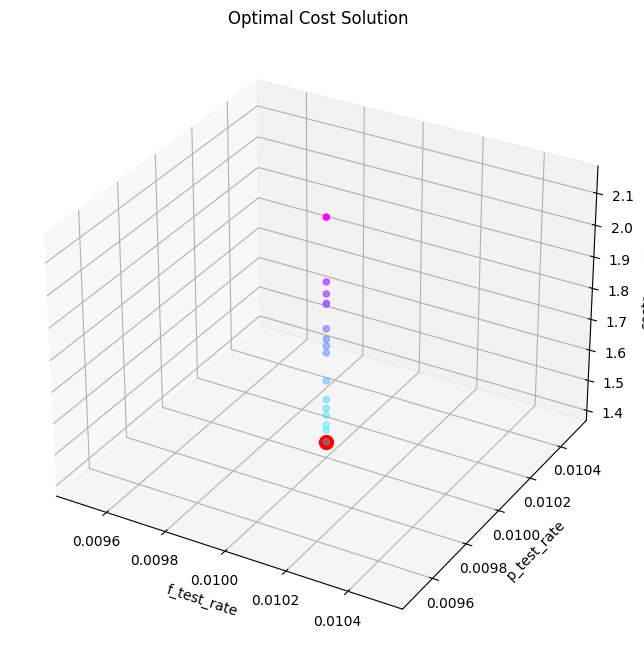

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Find the index of the minimum value in the costs_mean array
min_idx = np.argmin(costs_mean)

# Get the corresponding values of f_test_rate and p_test_rate
opt_f = ftest_rate[min_idx]
opt_p = ptest_rate[min_idx]
opt_cost = costs_mean[min_idx]

# Print the optimal values
print('Optimal f_test_rate:', opt_f)
print('Optimal p_test_rate:', opt_p)
print('Optimal cost:', opt_cost)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ftest_rate, ptest_rate, costs_mean, c=costs_mean, cmap='cool')
ax.scatter(opt_f, opt_p, opt_cost, c='red', s=100)
ax.set_xlabel('f_test_rate')
ax.set_ylabel('p_test_rate')
ax.set_zlabel('costs_mean')
ax.set_title('Optimal Cost Solution')
plt.show()


In [10]:
import concurrent.futures

iterations = 100
ftest_rate = []
ptest_rate = []
costs_mean = []
costs_std = []

def run_test_wrapper(f_test_rate, p_test_rate):
    costs = []
    for i in range(iterations):
        total_cost = run_test()
        costs.append(total_cost)
    return f_test_rate, p_test_rate, np.mean(costs), np.std(costs)

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for f_test_rate in tqdm(np.arange(0.01,0.05,0.01)):
        for p_test_rate in np.arange(0.01,0.05,0.01):
            futures.append(executor.submit(run_test_wrapper, f_test_rate, p_test_rate))
            
    for future in concurrent.futures.as_completed(futures):
        f_test_rate, p_test_rate, cost_mean, cost_std = future.result()
        ftest_rate.append(f_test_rate)
        ptest_rate.append(p_test_rate)
        costs_mean.append(cost_mean)
        costs_std.append(cost_std)


100%|██████████| 4/4 [00:00<00:00, 375.94it/s]


In [16]:
results[0]

<Future at 0x1642064a0 state=finished returned tuple>

100%|██████████| 59/59 [00:00<00:00, 636.90it/s]


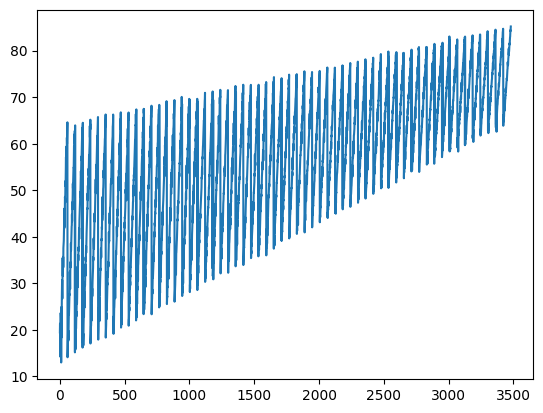

In [6]:

farm_population = 100
plot_per_farm = 50
box_per_plot = 50
contamination_rate = 0.06

d_test_rate = 0.0
r_test_rate = 0.0
c_test_rate = 0.0

box_ids_l=[]
box_ids_C_l=[]
dropped_boxes_F_l=[]
dropped_boxes_P_l=[]
dropped_boxes_D_l=[]
dropped_boxes_R_l=[]
dropped_boxes_C_l=[]
detection_percent_l=[]

for f_test_rate in tqdm(np.arange(0.01,0.6,0.01)):
    for p_test_rate in np.arange(0.01,0.6,0.01):
        box_ids,box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C = run_simulation(farm_population, plot_per_farm, box_per_plot, contamination_rate, f_test_rate, p_test_rate, d_test_rate, r_test_rate, c_test_rate)
        box_ids_l.append(len(box_ids))
        box_ids_C_l.append(len(box_ids_C))
        dropped_boxes_F_l.append(len(dropped_boxes_F))
        dropped_boxes_P_l.append(len(dropped_boxes_P))
        dropped_boxes_D_l.append(len(dropped_boxes_D))
        dropped_boxes_R_l.append(len(dropped_boxes_R))
        dropped_boxes_C_l.append(len(dropped_boxes_C))
        detection_percent = ((len(box_ids)-len(box_ids_C))/(contamination_rate*len(box_ids)))*100
        detection_percent_l.append(detection_percent)


def run_simulation_wrapper(args):
    f_test_rate, p_test_rate = args
    return run_simulation(farm_population, plot_per_farm, box_per_plot, contamination_rate, f_test_rate, p_test_rate, d_test_rate, r_test_rate, c_test_rate)

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = []
    for f_test_rate in tqdm(np.arange(0.0,1,0.1)):
        for p_test_rate in np.arange(0.01,0.5,0.01):
            results.append(executor.submit(run_simulation_wrapper, (f_test_rate, p_test_rate)))

    for future in concurrent.futures.as_completed(results):
        box_ids,box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C = future.result()
        box_ids_l.append(len(box_ids))
        box_ids_C_l.append(len(box_ids_C))
        dropped_boxes_F_l.append(len(dropped_boxes_F))
        dropped_boxes_P_l.append(len(dropped_boxes_P))
        dropped_boxes_D_l.append(len(dropped_boxes_D))
        dropped_boxes_R_l.append(len(dropped_boxes_R))
        dropped_boxes_C_l.append(len(dropped_boxes_C))
        detection_percent = ((len(box_ids)-len(box_ids_C))/(contamination_rate*len(box_ids)))*100
        detection_percent_l.append(detection_percent)

plt.plot(detection_percent_l)
plt.show()


In [7]:
# Define functions 
# Only contaminated box is removed after testing at each stage
import numpy as np
from tqdm import tqdm
import concurrent.futures
import numba as nb

# generate box id
#@nb.njit(nopython=True)
def generate_box_id(farm_idx, plot_idx, box_idx):
    return farm_idx * 10000000000 + plot_idx * 100000 + box_idx * 10

# generate contaminated box mask
#@nb.njit(parallel=True)
def generate_contamination_mask(total_boxes, contamination_rate):
    contaminated_boxes = int(total_boxes * contamination_rate)
    mask = np.zeros(total_boxes, dtype=np.bool_)
    mask[:contaminated_boxes] = True
    np.random.shuffle(mask)
    return mask

# define testing at each stage
def run_stage(box_ids, contamination_mask, test_rate):
    tested_boxes_mask = np.random.rand(box_ids.shape[0]) < test_rate
    tested_contaminated_boxes = box_ids[np.logical_and(contamination_mask, tested_boxes_mask)]
    if tested_contaminated_boxes.size > 0:
        mask = np.isin(box_ids, tested_contaminated_boxes)
        box_ids_n = box_ids[~mask]
        contamination_mask = contamination_mask[~mask]
        dropped_boxes = set(tested_contaminated_boxes)
    else:
        box_ids_n = box_ids
        dropped_boxes = set()
    remaining_boxes = box_ids_n[~np.isin(box_ids_n, tested_contaminated_boxes)]
    return remaining_boxes, contamination_mask, dropped_boxes

#@nb.njit(parallel=True) 
def isin(a, b):
    out=np.empty(a.shape[0], dtype=nb.boolean)
    b = set(b)
    for i in nb.prange(a.shape[0]):
        if a[i] in b:
            out[i]=True
        else:
            out[i]=False
    return out

# Run simulation
def run_simulation(farm_population, plot_per_farm, box_per_plot, contamination_rate, f_test_rate, p_test_rate,
                   d_test_rate, r_test_rate, c_test_rate):
    total_boxes = farm_population * plot_per_farm * box_per_plot
    box_ids = np.array([generate_box_id(farm_idx, plot_idx, box_idx)
                        for farm_idx in range(1,farm_population+1)
                        for plot_idx in range(1,plot_per_farm+1)
                        for box_idx in range(1,box_per_plot+1)])
    contamination_mask = generate_contamination_mask(total_boxes, contamination_rate)

    box_ids_F, contamination_mask, dropped_boxes_F = run_stage(box_ids, contamination_mask, f_test_rate)
    box_ids_P, contamination_mask, dropped_boxes_P = run_stage(box_ids_F, contamination_mask, p_test_rate)
    box_ids_D, contamination_mask, dropped_boxes_D = run_stage(box_ids_P, contamination_mask, d_test_rate)
    box_ids_R, contamination_mask, dropped_boxes_R = run_stage(box_ids_D, contamination_mask, r_test_rate)
    box_ids_C, contamination_mask, dropped_boxes_C = run_stage(box_ids_R, contamination_mask, c_test_rate)

    return box_ids, box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C


100%|██████████| 59/59 [00:00<00:00, 1941.82it/s]


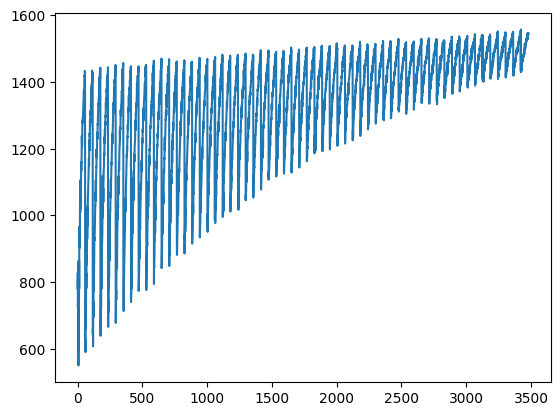

In [247]:
from tqdm import tqdm
import concurrent.futures
from matplotlib import pyplot as plt
farm_population = 100
plot_per_farm = 50
box_per_plot = 50
contamination_rate = 0.06

d_test_rate = 0.03
r_test_rate = 0.04
c_test_rate = 0.05

box_ids_l=[]
box_ids_C_l=[]
dropped_boxes_F_l=[]
dropped_boxes_P_l=[]
dropped_boxes_D_l=[]
dropped_boxes_R_l=[]
dropped_boxes_C_l=[]
detection_percent_l=[]

def run_simulation_wrapper(args):
    f_test_rate, p_test_rate = args
    return run_simulation(farm_population, plot_per_farm, box_per_plot, contamination_rate, f_test_rate, p_test_rate, d_test_rate, r_test_rate, c_test_rate)

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = []
    for f_test_rate in tqdm(np.arange(0.01,0.6,0.01)):
        for p_test_rate in np.arange(0.01,0.6,0.01):
            results.append(executor.submit(run_simulation_wrapper, (f_test_rate, p_test_rate)))

    for future in concurrent.futures.as_completed(results):
        box_ids,box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C = future.result()
        box_ids_l.append(len(box_ids))
        box_ids_C_l.append(len(box_ids_C))
        dropped_boxes_F_l.append(len(dropped_boxes_F))
        dropped_boxes_P_l.append(len(dropped_boxes_P))
        dropped_boxes_D_l.append(len(dropped_boxes_D))
        dropped_boxes_R_l.append(len(dropped_boxes_R))
        dropped_boxes_C_l.append(len(dropped_boxes_C))
        detection_percent = ((len(box_ids)-len(box_ids_C))/(contamination_rate*len(box_ids)))*100
        detection_percent_l.append(detection_percent)

plt.plot(detection_percent_l)
plt.show()
